In [97]:
# python=3.8
# conda env name : gender_pred_env

# Packges

In [137]:
import joblib
import numpy as np
import pandas as pd
import warnings
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Flatten, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusting warnings
warnings.filterwarnings('ignore')

In [105]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')
df.head()

,name,sex,name_length,last_letter,last_two_letters,first_letter,first_two_letters
0,ابتسام,0,6,م,ام,ا,اب
1,ابتهاج,0,6,ج,اج,ا,اب
2,ابتهال,0,6,ل,ال,ا,اب
3,اجتهاد,0,6,د,اد,ا,اج
4,ازدهار,0,6,ر,ار,ا,از


In [106]:
max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

# Tokenizing and padding the 'name' column for LSTM input
tokenizer = Tokenizer(num_words=vocab_size, char_level=True)  # char_level=True for character tokenization
tokenizer.fit_on_texts(df['name'])
sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)

In [127]:
first_letter = df['name'].apply(lambda x: x[0])
last_letter = df['name'].apply(lambda x: x[-1])

first_letter_encoded = np.array([ord(char) for char in first_letter])
last_letter_encoded = np.array([ord(char) for char in last_letter])

max_unicode_value_first = np.max(first_letter_encoded)
max_unicode_value_last = np.max(last_letter_encoded)
max_unicode_value = max(max_unicode_value_first, max_unicode_value_last)

In [129]:
scaler = MinMaxScaler()

first_letter_encoded_scaled = scaler.fit_transform(first_letter_encoded.reshape(-1, 1))
last_letter_encoded_scaled = scaler.fit_transform(last_letter_encoded.reshape(-1, 1))


scaler_first = scaler.fit(first_letter_encoded.reshape(-1, 1))
scaler_last = scaler.fit(last_letter_encoded.reshape(-1, 1))

# Save the scaler models to disk
joblib.dump(scaler_first, 'data/scaler_first.pkl')
joblib.dump(scaler_last, 'data/scaler_last.pkl');

In [130]:
# # # Preparing additional features
# # additional_features = df.iloc[:,2:].values
# # additional_features = additional_features.astype('float32')
# X = np.hstack((padded_sequences, [first_letter_encoded_scaled,last_letter_encoded_scaled]))
# y = df.sex

In [74]:
X = padded_sequences.copy()
y = df.sex

In [75]:
padded_sequences[43] , df['name'][43]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 28, 11,  2,  3]),
 'أسيل')

In [76]:
X.shape,y.shape

((8653, 17), (8653,))

In [77]:
# Define the size for the test and validation sets as percentages
test_size_percentage = 0.1
validation_size_percentage = 0.1

# Calculate the actual sizes for the test and validation sets
total_size = test_size_percentage + validation_size_percentage
test_size_actual = test_size_percentage / total_size
validation_size_actual = validation_size_percentage / total_size

# Calculate the training size percentage
train_size_percentage = 1 - total_size

# First split: Separate out the training data and the remaining data
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=total_size, random_state=11)

# Second split: Separate the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=test_size_actual, random_state=11)

# Print the shapes of the training, validation, and test sets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (6922, 17), (6922,)
Validation set shape: (865, 17), (865,)
Test set shape: (866, 17), (866,)


In [132]:
# max name length is 17

# Model parameters
embedding_dim = 512
letter_embedding_dim = 128

lstm_units = 64

total_features_shape = X.shape[1]  
l2_lambda = 0.001
dropout_rate = 0.2

batch_size = 32
epochs = 100

In [138]:
# Name input and embedding
name_input = Input(shape=(total_features_shape,), dtype='int32', name='name_input')
name_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=total_features_shape)(name_input)

# BiLSTM layers
bi_lstm_1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(name_embedding)
bi_lstm_1 = Dropout(dropout_rate)(bi_lstm_1)
bi_lstm_2 = Bidirectional(LSTM(lstm_units//2, kernel_regularizer=l2(l2_lambda), return_sequences=True))(bi_lstm_1)
bi_lstm_2 = Dropout(dropout_rate)(bi_lstm_2)
lstm_final = LSTM(lstm_units//4, kernel_regularizer=l2(l2_lambda))(bi_lstm_2)

# Inputs for the first and last letter
first_letter_input = Input(shape=(1,), dtype='int32', name='first_letter_input')
last_letter_input = Input(shape=(1,), dtype='int32', name='last_letter_input')

# Now use max_unicode_value in your embedding layer
first_letter_embedding = Embedding(input_dim=max_unicode_value + 1, output_dim=letter_embedding_dim, input_length=1)(first_letter_input)
last_letter_embedding = Embedding(input_dim=max_unicode_value + 1, output_dim=letter_embedding_dim, input_length=1)(last_letter_input)

# Flatten the embeddings of the first and last letters
first_letter_flat = Flatten()(first_letter_embedding)
last_letter_flat = Flatten()(last_letter_embedding)

# Concatenate the LSTM output with the first and last letter embeddings
concatenated = concatenate([lstm_final, first_letter_flat, last_letter_flat])

# Output layer for binary classification
output = Dense(1, activation='sigmoid')(concatenated)

# Define the model with multiple inputs
model = Model(inputs=[name_input, first_letter_input, last_letter_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model summary to verify architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 name_input (InputLayer)        [(None, 17)]         0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 17, 512)      18944       ['name_input[0][0]']             
                                                                                                  
 bidirectional_31 (Bidirectiona  (None, 17, 128)     295424      ['embedding_19[0][0]']           
 l)                                                                                               
                                                                                                  
 dropout_24 (Dropout)           (None, 17, 128)      0           ['bidirectional_31[0][0]']   

In [139]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# # Define the BiLSTM model adjusted for character-level input
# model = Sequential()

# model.add(Embedding(input_dim=vocab_size ,output_dim=embedding_dim, input_length=total_features_shape))

# model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))

# model.add(Dropout(dropout_rate))

# model.add(Bidirectional(LSTM(lstm_units//2, kernel_regularizer=l2(l2_lambda) ,return_sequences=True)))

# model.add(Dropout(dropout_rate))

# model.add(LSTM(lstm_units//4, kernel_regularizer=l2(l2_lambda)))

# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [80]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Gender Prediction Models Tracking")

<Experiment: artifact_location='mlflow-artifacts:/237850698007442871', creation_time=1704716553191, experiment_id='237850698007442871', last_update_time=1704716553191, lifecycle_stage='active', name='Gender Prediction Models Tracking', tags={}>

In [81]:
# MLflow tracking
with mlflow.start_run():
    # Log model parameters
    mlflow.log_params({
        "embedding_dim": embedding_dim,
        "lstm_units": lstm_units,
        "max_name_length": max_name_length,
        "vocab_size": vocab_size,
        "epochs": epochs,
        "batch_size": batch_size,
        "l2_reg": l2_lambda,
        "dropout_rate": dropout_rate,
        "train_size_percentage": train_size_percentage,
        "test_size_percentage": test_size_percentage,
        "validation_size_percentage": validation_size_percentage,
    })

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    # Log training history
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    mlflow.log_metrics({"val_loss": loss, "val_accuracy": accuracy})

    # Predictions and additional metrics
    y_pred = model.predict(X_test)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0).reshape(-1)
    f1 = f1_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Confusion matrix calculation
    cm = confusion_matrix(y_test, y_pred_classes)

    # Log additional metrics
    mlflow.log_metrics({"val_f1_score": f1,
     "val_precision": precision,
      "val_recall": recall,
     "val_roc_auc": roc_auc
     })

    # Log model architecture
    model_architecture_str = []

    # Define a function to append each line of the model summary to the list
    def append_model_summary(line):
        model_architecture_str.append(line)

    # Generate model summary
    model.summary(print_fn=append_model_summary)

    # Convert list to string
    model_architecture_str = '\n'.join(model_architecture_str)

    # Infer the signature using the combined data and predictions
    signature = infer_signature(X, y_pred)

    mlflow.keras.log_model(model, "model", signature=signature)

    # Set additional tags
    mlflow.set_tags({
        "Description": "Character-Level BiLSTM",
        "Encoding": "Character-Level with embedings",
        "Features": ', '.join(df.columns.tolist()),
        'Number of Features':len(df.columns.tolist()),
        "Model Type": "BiLSTM",
        "model_architecture": model_architecture_str,
        "confusion_matrix":cm
    })

print()
print('-----------------------------------------------------------')
print(f"Validation Accuracy: {round(accuracy, 3)}")
print(f"F1 Score: {round(f1, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"ROC AUC: {round(roc_auc, 3)}")
print('-----------------------------------------------------------')
# End MLflow run

Epoch 1/100
217/217 [==============================] - 26s 93ms/step - loss: 0.5541 - accuracy: 0.7962 - val_loss: 0.4004 - val_accuracy: 0.8428
Epoch 2/100
217/217 [==============================] - 19s 87ms/step - loss: 0.4134 - accuracy: 0.8305 - val_loss: 0.3873 - val_accuracy: 0.8497
Epoch 3/100
217/217 [==============================] - 20s 90ms/step - loss: 0.3948 - accuracy: 0.8370 - val_loss: 0.3648 - val_accuracy: 0.8509
Epoch 4/100
217/217 [==============================] - 19s 86ms/step - loss: 0.3823 - accuracy: 0.8376 - val_loss: 0.3767 - val_accuracy: 0.8451
Epoch 5/100
217/217 [==============================] - 18s 85ms/step - loss: 0.3765 - accuracy: 0.8435 - val_loss: 0.3507 - val_accuracy: 0.8624
Epoch 6/100
217/217 [==============================] - 18s 83ms/step - loss: 0.3649 - accuracy: 0.8476 - val_loss: 0.3609 - val_accuracy: 0.8509
Epoch 7/100
217/217 [==============================] - 19s 86ms/step - loss: 0.3614 - accuracy: 0.8472 - val_loss: 0.3436 - val_ac

INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmp53lqbffm\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmp53lqbffm\model\data\model\assets



-----------------------------------------------------------
Validation Accuracy: 0.845
F1 Score: 0.896
Precision: 0.885
Recall: 0.907
ROC AUC: 0.899
-----------------------------------------------------------


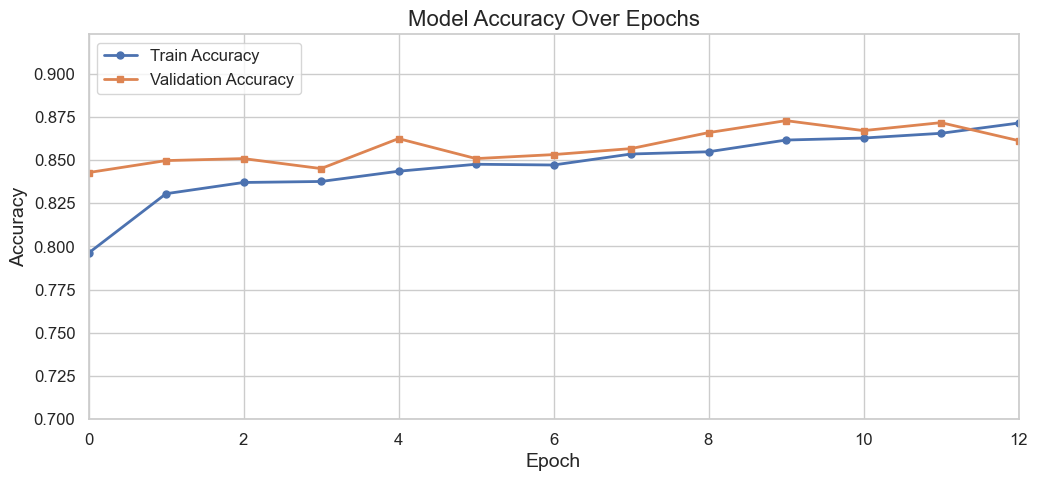

In [82]:
# Apply the seaborn style to make plots nicer
sns.set(style="whitegrid")

# Create the figure with a specific size
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o', markersize=5)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=5)

# Title and labels
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Legend
plt.legend(loc='upper left', fontsize=12)

# Set limits and ticks for readability
plt.xlim(0, len(history.history['accuracy']) - 1)
plt.ylim(0.7, max(max(history.history['accuracy']), max(history.history['val_accuracy'])) + 0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Text(92.25, 0.5, 'True Label')

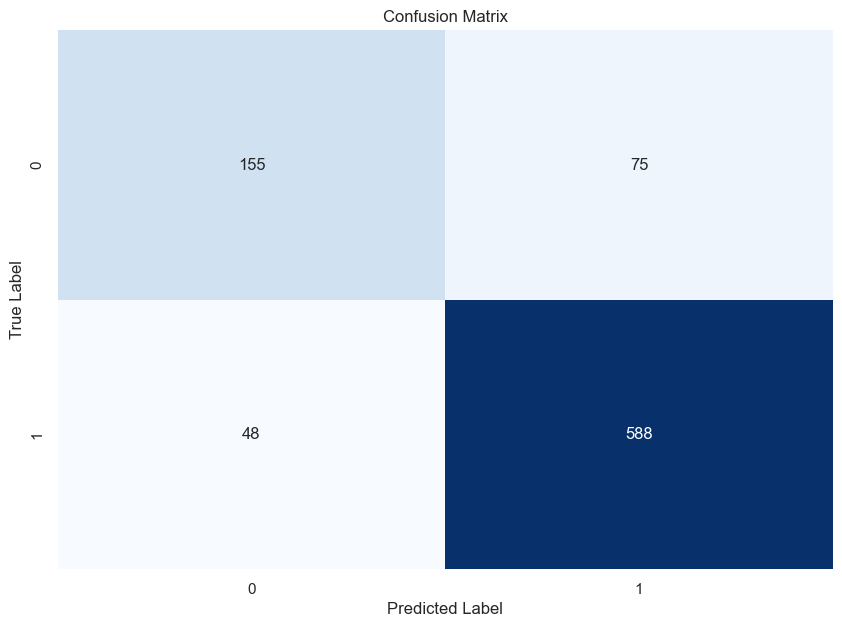

In [83]:
# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [84]:
# model.save("BiLSTM-87_val_acc-91_f_sc.h5")